# MessMaster: the Curse of the Muffin-Faced Dog (part 2)

<div>
<img src="media/domino_meme.png" width="400"/>
</div>

Welcome back to the quest of MessMaster! 

This week, we will continue to help Boltzmann differentiate Chihuahuas and blueberry muffins, but with fancier models (no longer just linear)!

<div>
<img src="../lab2/media/chihuahua_muffin.png" width="400"/>
</div>

Specifically we will use the following concepts:

- Backprop: implementation and visualization
- MLP: decision boundary and contrast with linear models
- Optimization: Comparing SGD v.s. Adam
- Model selection: generalization bound, bias-variance trade-off and uncertainty intervals


A friend has helped us found a separable 2D embedding of Chihuahuas and blueberry muffins.
However, the decision boundary is not linear.

<div>
<img src="secret/data/xor_pattern_label.png" width="400"/>
</div>


We will train a MLP to help with this!


#### 1. ManualGrad: handcrafted gradients, artisanal machine learning

In [1]:
RANDOM_SEED = 10011 # postal code of CDS <3

First we will load the data and split it into train/val/test sets.

**Q1a.** Why is it important to have validation and test sets?

Answer:

In [2]:
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

# load data
df = pd.read_csv("secret/data/xor_pattern.csv")
X = df[["x1", "x2"]].values  # Extract features
y = df["y"].values  #

# train-val-test split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=RANDOM_SEED)
# TODO: what is the train-val-test split ratio?

# convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

**Q1b.** Implement the CEL loss function for binary classification. What is its connection to energy?

In [3]:
def loss_fn(p_y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the cross-entropy loss (negative log likelihood) of a prediction.
    p_y_hat: probability of each class, shape (N, 2)
    y: true class, shape (N,)
    returns: loss, shape (1,)
    """
    # TODO: implement the loss function
    correct_class_loc = [range(y.shape[0]), y]
    correct_class_prob = p_y_hat[correct_class_loc]
    nll = -torch.mean(torch.log(correct_class_prob))
    return nll
    # return 0 

**Q1c.** 

i. What does derivative/gradient tells us about a function? (What does positive/negative gradient mean?)

ii. Why is it useful for optimization?

iii. What is chain rule?

Answer: 

i. The derivative of a function tells us the rate of change of the function. A positive derivative means the function is increasing with the parameter, and a negative derivative means the function is decreasing with the parameter.

ii. It is useful for optimization because we can use it to find the minimum or maximum of a function.

iii. The chain rule is a rule in calculus for differentiating the composition of two functions. If $f(x) = h(g(x))$, then $f'(x) = h'(g(x)) * g'(x)$.

**Q1d.**

We are going to implement a two-layer MLP with ReLU activation and softmax output. Training with gradient descent.

First layer: $z_1 = h_1(x) = \sigma(W_1 x + b_1)=\sigma(a_1)$

Second layer: $z_2 = h_2(x) = W_2 z_1 + b_2$

Softmax: $\hat{p} = \text{softmax}(z_2) = \frac{e^{z_2}}{\sum_{j=1}^{2} e^{z_{2j}}}$

Loss function: $L(y, p_{\hat{y}}) = \text{L}_{\text{ce}}(y, p_{\hat{y}}) = - \log \hat{p}(\hat{y}=y)$

Consider computing the gradient of the loss function with respect to the parameters.

Let's focus on the first layer. What is $\frac{\partial L}{\partial W_1}$?

You may use the fact that $\frac{\partial L}{\partial z_2} = \hat{p} - y$ and that $\sigma'(a) = 1(\sigma(a) > 0)$, where $1(\cdot)$ is the indicator function.


Answer:

$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial z_2} \frac{\partial z_2}{\partial z_1} \frac{\partial z_1}{\partial W_1}$

$\frac{\partial z_2}{\partial z_1} = W_2$

$\frac{\partial z_1}{\partial W_1} = \text{diag} (1(W_1 x + b_1 > 0)) x^\top$




Training (todo: fill in gradients)

In [4]:
# Initialize weights
W1 = torch.randn(2, 10, requires_grad=False) * 0.01
b1 = torch.zeros(10, requires_grad=False)
W2 = torch.randn(10, 2, requires_grad=False) * 0.01
b2 = torch.zeros(2, requires_grad=False)

learning_rate = 0.1
epochs = 10000

for epoch in range(epochs):
    # =================== Forward pass ===================
    # First layer: z1 = W1 * X + b1
    z1 = X_train_tensor @ W1 + b1  # Shape: (N, h)  [batch_size, hidden_dim]

    # Apply activation function: a1 = ReLU(z1)
    a1 = torch.relu(z1)  # Shape: (N, h)

    # Second layer: z2 = W2 * a1 + b2
    z2 = a1 @ W2 + b2  # Shape: (N, k)  [batch_size, num_classes]

    # Apply softmax to get probabilities: p_hat = softmax(z2)
    p_hat = torch.softmax(z2, dim=1)   # Shape: (N, k)

    # =================== Compute Loss ===================
    # PyTorch's CrossEntropyLoss automatically applies softmax inside,
    # so we should pass raw logits (z2), not softmax probabilities (p_hat)
    loss = loss_fn(p_hat, y_train_tensor)  # Scalar loss value

    # =================== Backpropagation ===================

    # Step 1: Compute gradient of loss w.r.t. logits (z2)
    # Cross-entropy loss with softmax:
    #   L = - (1/N) * sum(y * log(p_hat))
    # Derivative:
    #   dL/dz2 = (p_hat - y) / N
    # Shape: (N, k) [Same as z2]
    y_one_hot = torch.nn.functional.one_hot(y_train_tensor, num_classes=p_hat.shape[1]).float()  # Shape: (N, k)
    dL_dz2 = (p_hat - y_one_hot) / y_train_tensor.shape[0]  # Normalize by batch size

    # Step 2: Compute gradient of loss w.r.t. W2 and b2
    # Using chain rule: dL/dW2 = (dL/dz2) * (dz2/dW2)
    #   dz2/dW2 = a1^T
    #   dL/dW2 = a1^T @ dL/dz2
    # Shape: (h, k) [Same as W2]
    dL_dW2 = a1.T @ dL_dz2

    # Gradient of loss w.r.t. b2:
    #   dL/db2 = sum(dL/dz2) along batch axis
    # Shape: (k,) [Same as b2]
    dL_db2 = torch.sum(dL_dz2, dim=0)

    # Step 3: Compute gradient of loss w.r.t. activations (a1)
    #   dL/da1 = (dL/dz2) * (dz2/da1)
    #   dz2/da1 = W2^T
    #   dL/da1 = dL/dz2 @ W2^T
    # Shape: (N, h) [Same as a1]
    dL_da1 = dL_dz2 @ W2.T

    # Step 4: Compute gradient of loss w.r.t. pre-activation (z1)
    # Using chain rule: dL/dz1 = (dL/da1) * (da1/dz1)
    # ReLU derivative:
    #   da1/dz1 = 1 if z1 > 0, else 0
    # Shape: (N, h) [Same as z1]
    dL_dz1 = dL_da1 * (z1 > 0).float()

    # Step 5: Compute gradient of loss w.r.t. W1 and b1
    # Using chain rule: dL/dW1 = (dL/dz1) * (dz1/dW1)
    #   dz1/dW1 = X^T
    #   dL/dW1 = X^T @ dL/dz1
    # Shape: (d, h) [Same as W1]
    dL_dW1 = X_train_tensor.T @ dL_dz1

    # Gradient of loss w.r.t. b1:
    #   dL/db1 = sum(dL/dz1) along batch axis
    # Shape: (h,) [Same as b1]
    dL_db1 = torch.sum(dL_dz1, dim=0)

    # Gradient update (SGD step)
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.6931
Epoch 10: Loss = 0.6910
Epoch 20: Loss = 0.6902
Epoch 30: Loss = 0.6899
Epoch 40: Loss = 0.6898
Epoch 50: Loss = 0.6897
Epoch 60: Loss = 0.6895
Epoch 70: Loss = 0.6894
Epoch 80: Loss = 0.6893
Epoch 90: Loss = 0.6891
Epoch 100: Loss = 0.6888
Epoch 110: Loss = 0.6885
Epoch 120: Loss = 0.6880
Epoch 130: Loss = 0.6875
Epoch 140: Loss = 0.6868
Epoch 150: Loss = 0.6859
Epoch 160: Loss = 0.6847
Epoch 170: Loss = 0.6833
Epoch 180: Loss = 0.6815
Epoch 190: Loss = 0.6792
Epoch 200: Loss = 0.6763
Epoch 210: Loss = 0.6728
Epoch 220: Loss = 0.6686
Epoch 230: Loss = 0.6636
Epoch 240: Loss = 0.6578
Epoch 250: Loss = 0.6510
Epoch 260: Loss = 0.6433
Epoch 270: Loss = 0.6346
Epoch 280: Loss = 0.6248
Epoch 290: Loss = 0.6139
Epoch 300: Loss = 0.6019
Epoch 310: Loss = 0.5886
Epoch 320: Loss = 0.5742
Epoch 330: Loss = 0.5588
Epoch 340: Loss = 0.5426
Epoch 350: Loss = 0.5257
Epoch 360: Loss = 0.5083
Epoch 370: Loss = 0.4907
Epoch 380: Loss = 0.4729
Epoch 390: Loss = 0.4551
Epoch 400: 

Visualization

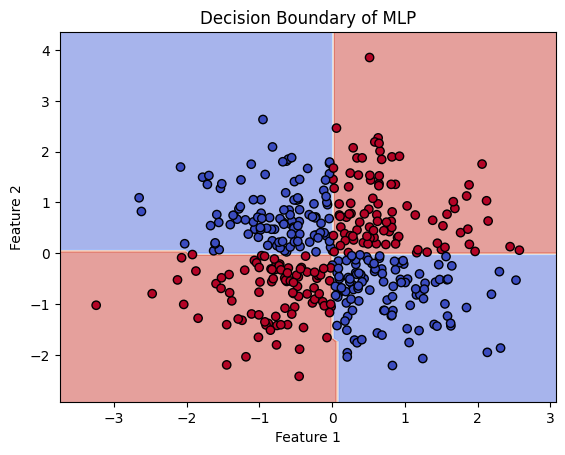

In [5]:

from util import plot_decision_boundary
# Example usage:
plot_decision_boundary(W1, b1, W2, b2, X_train_tensor.numpy(), y_train_tensor.numpy())


#### 2. Optimizers:Adam v.s. SGD

In [13]:
import torch
import torch.nn.functional as F

W1.requires_grad = True
W2.requires_grad = True
b1.requires_grad = True
b2.requires_grad = True
# Hyperparameters
epochs = 100
batch_size = 32
learning_rate = 0.1 #1e-3

# Initialize weights with Xavier (Glorot) initialization
torch.manual_seed(RANDOM_SEED)  # For reproducibility
torch.nn.init.xavier_uniform_(W1)
torch.nn.init.xavier_uniform_(W2)
b1.data.fill_(0)
b2.data.fill_(0)

# Define two optimizers: SGD and Adam
optimizer_sgd = torch.optim.SGD([W1, b1, W2, b2], lr=learning_rate)
optimizer_adam = torch.optim.Adam([W1, b1, W2, b2], lr=learning_rate)

# Learning rate schedulers (optional)
scheduler_sgd = torch.optim.lr_scheduler.StepLR(optimizer_sgd, step_size=20, gamma=0.5)  # Decay every 20 epochs
scheduler_adam = torch.optim.lr_scheduler.StepLR(optimizer_adam, step_size=20, gamma=0.5)

# Store loss & lr history
loss_history_sgd, loss_history_adam = [], []
lr_history_sgd, lr_history_adam = [], []

# Training loop for both optimizers
for optimizer_name, optimizer, loss_history, lr_history, scheduler in [
    ("SGD", optimizer_sgd, loss_history_sgd, lr_history_sgd, scheduler_sgd),
    ("Adam", optimizer_adam, loss_history_adam, lr_history_adam, scheduler_adam),
]:
    print(f"\nTraining with {optimizer_name}...\n")

    # Reset weights for fair comparison
    torch.nn.init.xavier_uniform_(W1)
    torch.nn.init.xavier_uniform_(W2)
    b1.data.fill_(0)
    b2.data.fill_(0)

    for epoch in range(epochs):
        # =================== Forward pass ===================
        z1 = X_train_tensor @ W1 + b1
        a1 = torch.relu(z1)
        z2 = a1 @ W2 + b2
        loss = F.cross_entropy(z2, y_train_tensor)

        # =================== Backward pass ===================
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        # Save loss & learning rate
        loss_history.append(loss.item())

        lr_history.append(optimizer.param_groups[0]["lr"])  # Extract current lr

        # Learning rate decay (if scheduler exists)
        scheduler.step()

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(
                f"{optimizer_name} - Epoch {epoch}: Loss = {loss.item():.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}"
            )


Training with SGD...

SGD - Epoch 0: Loss = 0.7869, LR = 0.100000
SGD - Epoch 10: Loss = 0.6714, LR = 0.100000
SGD - Epoch 20: Loss = 0.6108, LR = 0.050000
SGD - Epoch 30: Loss = 0.5880, LR = 0.050000
SGD - Epoch 40: Loss = 0.5690, LR = 0.025000
SGD - Epoch 50: Loss = 0.5608, LR = 0.025000
SGD - Epoch 60: Loss = 0.5530, LR = 0.012500
SGD - Epoch 70: Loss = 0.5493, LR = 0.012500
SGD - Epoch 80: Loss = 0.5456, LR = 0.006250
SGD - Epoch 90: Loss = 0.5438, LR = 0.006250

Training with Adam...

Adam - Epoch 0: Loss = 0.8531, LR = 0.100000
Adam - Epoch 10: Loss = 0.3232, LR = 0.100000
Adam - Epoch 20: Loss = 0.1262, LR = 0.050000
Adam - Epoch 30: Loss = 0.0926, LR = 0.050000
Adam - Epoch 40: Loss = 0.0737, LR = 0.025000
Adam - Epoch 50: Loss = 0.0680, LR = 0.025000
Adam - Epoch 60: Loss = 0.0635, LR = 0.012500
Adam - Epoch 70: Loss = 0.0615, LR = 0.012500
Adam - Epoch 80: Loss = 0.0598, LR = 0.006250
Adam - Epoch 90: Loss = 0.0589, LR = 0.006250


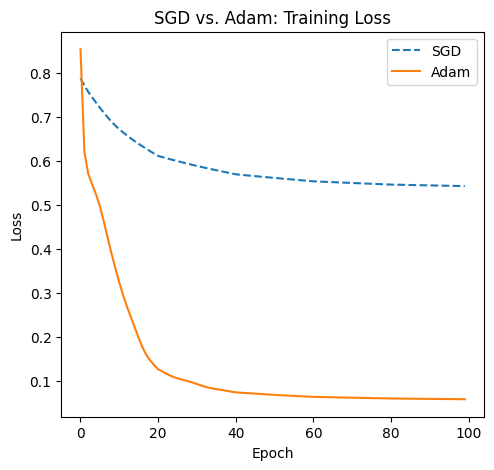

In [12]:
from util import plot_loss
plot_loss(loss_history_sgd, loss_history_adam)

#### 3. Model Selection: case study of polynomial fitting

**Bias-variance trade-off**

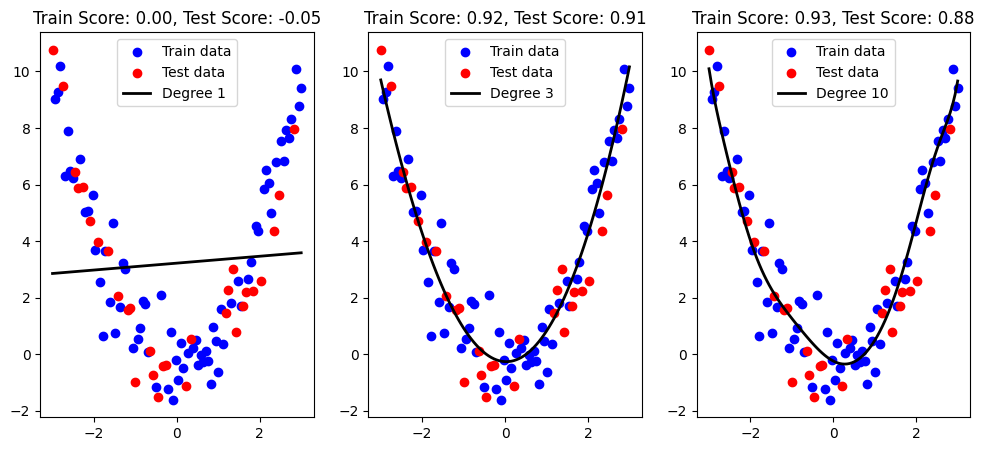

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Generate synthetic data
np.random.seed(0)
X = np.linspace(-3, 3, 100).reshape(-1, 1)
# 2nd order polynomial
y = X**2 + np.random.normal(0, 1, X.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Try different polynomial degrees
degrees = [1, 3, 10]
plt.figure(figsize=(12, 5))

for i, d in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    X_plot = np.linspace(-3, 3, 100).reshape(-1, 1)
    y_pred = model.predict(X_plot)

    plt.subplot(1, len(degrees), i + 1)
    plt.scatter(X_train, y_train, color="blue", label="Train data")
    plt.scatter(X_test, y_test, color="red", label="Test data")
    plt.plot(X_plot, y_pred, color="black", lw=2, label=f"Degree {d}")
    plt.title(f"Train Score: {train_score:.2f}, Test Score: {test_score:.2f}")
    plt.legend()

plt.show()


**Generalization Bound**

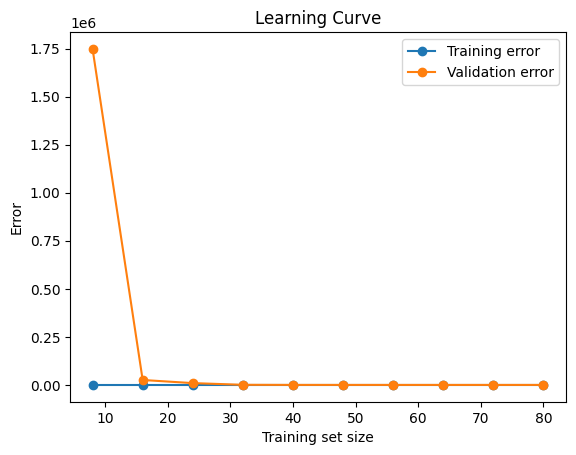

In [16]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring="neg_mean_squared_error"
    )

    train_errors = -train_scores.mean(axis=1)
    val_errors = -val_scores.mean(axis=1)

    plt.plot(train_sizes, train_errors, label="Training error", marker="o")
    plt.plot(train_sizes, val_errors, label="Validation error", marker="o")
    plt.xlabel("Training set size")
    plt.ylabel("Error")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()


# Example usage
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
plot_learning_curve(model, X, y)

**Confidence Intervals**

/Users/lavender/Desktop/DS-GA-1003-Machine-Learning-2025/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


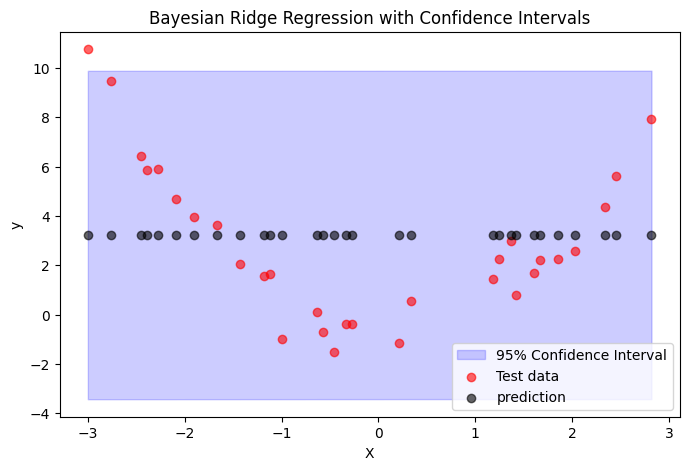

In [32]:
from sklearn.linear_model import BayesianRidge

# Train Bayesian regression model
bayes_model = BayesianRidge()
bayes_model.fit(X_train, y_train)

# Predict with uncertainty estimation
y_pred, std_dev = bayes_model.predict(X_test, return_std=True)

# # Plot predictions with uncertainty
# plt.scatter(X_test, y_test, color="red", label="Test data")
# # plt.scatter(X_train, y_train, color="blue", label="Train data")
# plt.scatter(X_test, y_pred, label="Mean prediction", color="black")
# plt.fill_between(
#     X_test.ravel(), y_pred - 2 * std_dev, y_pred + 2 * std_dev, alpha=0.2, color="blue", label="95% Confidence Interval"
# )
# plt.legend()
# plt.show()

# Sort test set for proper plotting
sort_idx = np.argsort(X_test.ravel())  # Get sorted indices
X_sorted = X_test.ravel()[sort_idx]
y_pred_sorted = y_pred[sort_idx]
std_dev_sorted = std_dev[sort_idx]

# Plot predictions with corrected confidence intervals
plt.figure(figsize=(8, 5))
plt.fill_between(
    X_sorted,
    y_pred_sorted - 2 * std_dev_sorted,
    y_pred_sorted + 2 * std_dev_sorted,
    alpha=0.2,
    color="blue",
    label="95% Confidence Interval",
)
plt.scatter(X_test, y_test, color="red", label="Test data", alpha=0.6)
plt.scatter(X_sorted, y_pred_sorted, label="prediction", color="black", alpha=0.6)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Bayesian Ridge Regression with Confidence Intervals")
plt.legend(loc="lower right")
plt.show()

**Hyperparameter tuning: degree of polynomial**

In [18]:
from sklearn.model_selection import GridSearchCV

# Define model pipeline
model = make_pipeline(PolynomialFeatures(), LinearRegression())

# Define hyperparameters to search over
param_grid = {"polynomialfeatures__degree": [1, 2, 3, 5, 10]}

# Perform cross-validation grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Best model
print(f"Best degree: {grid_search.best_params_['polynomialfeatures__degree']}")

Best degree: 2
